In [1]:
from math import sin, cos, pi      #数学関数・定数のインポート
import numpy as np                 #数値計算機能のインポート 別名np
import matplotlib.pyplot as plt    #グラフ描画機能のインポート 別名plt
from ipywidgets import interact    #対話的処理機能のインポート
import numpy.linalg as la          #線形代数をインポート 別名la
from scipy.integrate import odeint #常微分方程式の解法をインポート
from matplotlib.animation import FuncAnimation #アニメーション機能のインポート
from matplotlib import rc          #各種設定機能のインポート
rc('animation', html='jshtml')     #Colabでアニメーション表示可能にするための設定

# 車輪型倒立ロボット (wheeled inverted pendulum)

### 運動方程式の定義

#### (1) トルクを与える関数

In [2]:
def Torque(state):

  # 車輪角度，車輪角速度，倒れ角，倒れ角速度
  alpha, dalpha, beta, dbeta = state

  # トルク
  T = 0 #ひとまず0にしておく
  # T = 1* alpha + 0.5* dalpha + 40* beta + 4* dbeta #後で使う

  return T

#### (2) 運動方程式 (equation of motion)

In [3]:
# パラメータの設定（適当に定めた）
M, J, m, r, l = 1, 0.1, 5, 0.2, 1
g = 9.8 #重力加速度

def EOM(x, t):

  # トルク
  T = Torque(x)
  
  # 一般化力
  FT = np.array([T, -T])

  # 車輪角度，車輪角速度，倒れ角，倒れ角速度
  alpha, dalpha, beta, dbeta = x

  # 左辺の行列
  A = np.array([
    [ (M + m)*(r**2) + J, m*l*r*cos( beta )],
    [ m*l*r*cos( beta ),  m*(l**2)]
  ])

  # 右辺のベクトル
  bb = np.array([ 
    m*l*r*( dbeta**2 )*sin( beta ),
    m*g*l*sin( beta )
  ]) + FT

  # 線形方程式を解く
  invA = la.inv(A) #Aの逆行列
  hh = np.dot(invA, bb)

  # 1階化した運動方程式の右辺
  dx = np.array([
    dalpha,
    hh[0],
    dbeta,
    hh[1]
  ])

  return dx

### 運動方程式の数値解

#### (3) 時間軸の作成

In [4]:
t0 = 0    #初期時刻
dt = 0.01 #時間ステップ
tn = 1001 #データ長
t1 = t0 + dt*(tn-1) #終端時刻

ts = np.linspace(t0, t1, tn) #時間軸を表す等差数列
ts

array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ])

#### (4) 数値積分

In [5]:
x0 = np.array([0, 0, 0.2, 0]) #初期状態

solution = odeint(EOM, x0, ts)      #運動方程式の数値解を求める
solution

array([[ 0.00000000e+00,  0.00000000e+00,  2.00000000e-01,
         0.00000000e+00],
       [-6.45186573e-04, -1.29053033e-01,  2.00223830e-01,
         4.47724932e-02],
       [-2.58168934e-03, -2.58294631e-01,  2.00895709e-01,
         8.96226458e-02],
       ...,
       [ 3.51263443e+00, -1.26337145e+00,  4.61884791e+00,
        -4.59875680e+00],
       [ 3.49667995e+00, -1.93501416e+00,  4.57230095e+00,
        -4.71175772e+00],
       [ 3.47377886e+00, -2.65325742e+00,  4.52458896e+00,
        -4.83190258e+00]])

#### 時間波形の確認


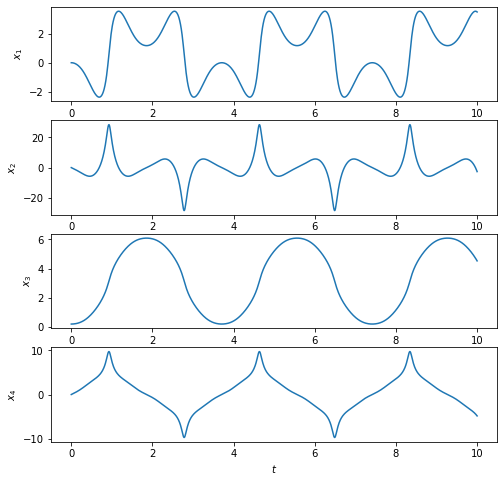

In [6]:
fig, axs= plt.subplots(4, 1, figsize=(8,8)) #グラフ用紙(axs)を4行,1列(4枚)用意

for i in range(4):
  ax = axs[i]
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x_%d$' %(i+1))

  xs = solution[:,i]
  ax.plot(ts, xs) 

### 数値解のアニメーション

#### アニメーション用のユーザー関数

In [7]:
def display_motion(solution):

  #数値解を10個おきに間引いて（時間方向）描画を軽くする
  skipped_solution = solution[::10,:] 

  #each_frameで使う回転行列
  def Rot(angle):
    R = np.array([
      [cos(angle), -sin(angle)],            
      [sin(angle),  cos(angle)],            
    ])
    return R

  #グラフ用紙の設定
  fig, ax= plt.subplots(1, 1, figsize=(8,3)) #グラフ用紙(ax)を1行,1列(1枚)用意

  #アニメーションの１コマの描画
  def each_frame(i):
    ax.cla() #グラフ用紙を白紙にリセット
    ax.set_xlim(-4,4) #x軸の範囲
    ax.set_ylim(-1,2) #y軸の範囲
    ax.grid()

    #i番目の数値解
    xs = skipped_solution[i,:]

    #一般化座標の値
    alpha, beta = xs[0], xs[2]

    #特徴点の座標
    x = r*xs[0] #水平変位
    xM = np.array([x, r]) #車輪の中心
    xm = np.array([x+l*sin(beta), r+cos(beta)]) #振り子の先端

    #振り子棒の描画
    ax.plot([xM[0], xm[0]], [xM[1], xm[1]], linewidth=3)

    #車輪の描画(n角形で近似)
    n = 5
    angles = np.linspace(0, 2*pi*(n-1)/n, n) #1周をn等分
    angles = np.append(angles, angles[0]) #終点＝始点を追加し，図形を閉じる 
    wheel = r * np.array(
            [np.cos(angles), np.sin(angles)]
          ) #数列を一括で三角関数するときは cos, sin の代わりに np.cos, np.sin

    moving_wheel = [] #Pythonの汎用リスト構造（空）
    for point in wheel.T:
      newpoint = np.dot(Rot(-alpha), point) #回転
      newpoint = newpoint + xM              #平行移動
      moving_wheel.append(newpoint) #リストに追加

    moving_wheel = np.array(moving_wheel) #リストをNumpy配列化

    ax.plot(moving_wheel[:, 0], moving_wheel[:, 1])

  #アニメーションデータの作成
  anim = FuncAnimation(
      fig, 
      each_frame,
      interval=80,
      frames=len(skipped_solution)
  )
  
  return anim

#### (5) 数値解のアニメーション表示

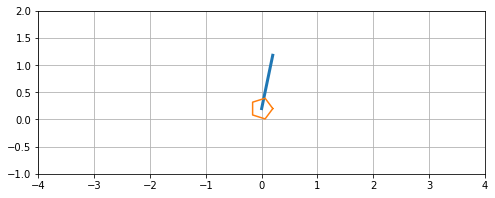

In [8]:
display_motion(solution)

### 実習3.1
- 実習3.1は，上記の実行例で完了していますが，
- 後続の実習に必要な部分だけ集めて，再実行しておきます．実行結果は上記と同じです．

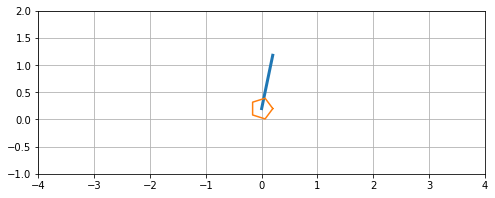

In [9]:
### (1) トルクを与える関数
def Torque(state):

  # 車輪角度，車輪角速度，倒れ角，倒れ角速度
  alpha, dalpha, beta, dbeta = state

  # トルク
  T = 0 #ひとまず0にしておく
  # T = 1* alpha + 0.5* dalpha + 40* beta + 4* dbeta #後で使う

  return T

### (2) 運動方程式　※共通なので再掲せず

### (3) 時間軸の作成
t0 = 0    #初期時刻
dt = 0.01 #時間ステップ
tn = 1001 #データ長
t1 = t0 + dt*(tn-1) #終端時刻
ts = np.linspace(t0, t1, tn) #時間軸を表す等差数列

### (4) 数値積分
x0 = np.array([0, 0, 0.2, 0]) #初期状態
solution = odeint(EOM, x0, ts)      #運動方程式の数値解を求める

### (5) 数値解のアニメーション表示
display_motion(solution)

### 実習3.2
- 下記の関数Torque(state)の中の`T`を，`T = 1* alpha + 0.5* dalpha + 40* beta + 4* dbeta`に書き換えて実行せよ．

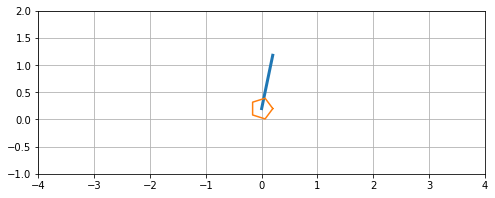

In [10]:
### (1) トルクを与える関数
def Torque(state):

  # 車輪角度，車輪角速度，倒れ角，倒れ角速度
  alpha, dalpha, beta, dbeta = state

  # トルク
  T = 0 #ひとまず0にしておく
  # T = 1* alpha + 0.5* dalpha + 40* beta + 4* dbeta #後で使う

  return T

### (2) 運動方程式　※共通なので再掲せず

### (3) 時間軸の作成
t0 = 0    #初期時刻
dt = 0.01 #時間ステップ
tn = 1001 #データ長
t1 = t0 + dt*(tn-1) #終端時刻
ts = np.linspace(t0, t1, tn) #時間軸を表す等差数列

### (4) 数値積分
x0 = np.array([0, 0, 0.2, 0]) #初期状態
solution = odeint(EOM, x0, ts)      #運動方程式の数値解を求める

### (5) 数値解のアニメーション表示
display_motion(solution)